# **Regression: Covid-19 Risk Prediction Notebook**

## Objectives

Fit and evaluate a regression model to predict the risk level for a Covid-19 patient based on their age and pre-existing health conditions.

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict Risk level of patient
* Labels map
* Feature Importance Plot 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study'

---

## Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/covid-19-dataset.csv")
df['DIED'] = df['DIED'].map({'Yes': 1, 'No': 0})
df = df.drop(labels=['ICU', 'USMER', 'MEDICAL_UNIT'], axis=1)

print(df.shape)
df.head(3)

(62236, 15)


,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DIED
0,Male,No,No,76,No,No,No,No,Yes,Yes,No,No,No,No,0
1,Male,No,Yes,91,Yes,No,No,No,Yes,No,No,No,No,No,0
2,Male,No,Yes,39,No,No,No,No,No,No,No,No,No,No,1


---

## MP Pipeline: Regressor

#### Create ML pipeline

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 
                       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
                       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
        )),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
            variables=None,
            method="spearman",
            threshold=0.6,
            selection_method="variance"
        )),

        ("feat_scaling", StandardScaler()),

        ("feat_selection", SelectFromModel(model)),

        ("model", model),
    ])
    return pipeline_base

#### Custom Class for hyperparameter optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

#### Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(['DIED'], axis=1)
y = df['DIED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (49788, 14) (49788,) 
* Test set: (12448, 14) (12448,)


### Grid Search CV - Sklearn

#### Use default hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': [100, 200]
    },
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

hyperparameter optimisation search using default hyperparameters

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check Results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                    estimator min_score mean_score max_score std_score  \
16  GradientBoostingRegressor    0.1601   0.163906  0.168607  0.002929   
14        ExtraTreesRegressor  0.156578   0.161011  0.165709  0.002981   
12      DecisionTreeRegressor  0.156578    0.16101  0.165709  0.002974   
13      RandomForestRegressor  0.156304   0.160965  0.165652  0.003019   
15          AdaBoostRegressor  0.156799   0.160084  0.164321  0.002845   
17               XGBRegressor  0.120535   0.123844  0.127833  0.002495   
1          LogisticRegression -0.282336  -0.268251 -0.257636  0.010283   
11         LogisticRegression -0.282336  -0.268251 -0.257636  0.010283   
10         LogisticRegression -0.282336  -0.268251 -0.257636  0.010283   
0          LogisticRegression -0.282336  -0.268251 -0.257636  0.010283   
8          LogisticRegression -0.282336  -0.268251 -0.257636  0.010283   
7          LogisticRegression -0.282336  -0.268251 -0.257636  0.010283   
6          LogisticRegression -0.28233

#### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [11]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3], 
        'model__max_depth': [3, 10, None],
    }
}

Extensive GridSearch CV

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check Results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                    estimator min_score mean_score max_score std_score  \
0   GradientBoostingRegressor    0.1601   0.163906  0.168607  0.002929   
7   GradientBoostingRegressor  0.160389   0.163784  0.168215    0.0028   
1   GradientBoostingRegressor  0.158379   0.162851  0.167754  0.003103   
9   GradientBoostingRegressor  0.156958   0.161058  0.165694  0.002869   
2   GradientBoostingRegressor  0.156581   0.161011  0.165709  0.002973   
4   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002973   
3   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002974   
5   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002974   
11  GradientBoostingRegressor  0.156803   0.160988  0.165619  0.002883   
8   GradientBoostingRegressor  0.138681   0.141307  0.145142  0.002236   
6   GradientBoostingRegressor  0.139238   0.141289  0.144583  0.001978   
10  GradientBoostingRegressor  0.138575   0.141251  0.145042  0.002215   
15  GradientBoostingRegressor   0.0730

Check the best model

In [14]:
best_model = grid_search_summary.iloc[0, 0]
print(best_model)

GradientBoostingRegressor


Parameters for best model

In [15]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor, based on search

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
print(best_regressor_pipeline)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
                   

### Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['INTUBED', 'AGE']


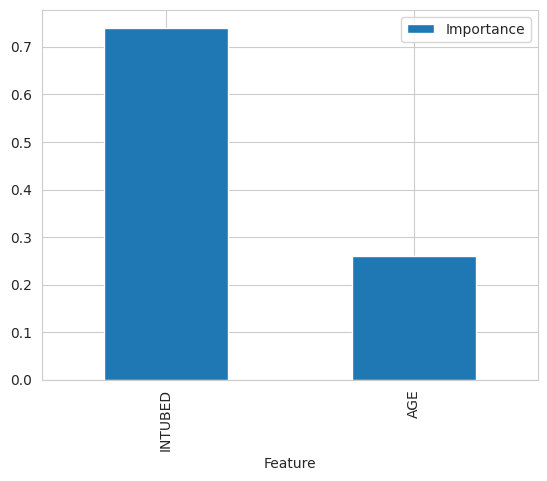

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 2
pipeline_cleaning_feat_eng = Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
X_transformed = pipeline_cleaning_feat_eng.fit_transform(X_train)
columns_after_data_cleaning_feat_eng = X_train.columns

selected_features_mask = best_regressor_pipeline['feat_selection'].get_support()
best_features = columns_after_data_cleaning_feat_eng[selected_features_mask].to_list()

df_feature_importance = pd.DataFrame({
    'Feature': best_features,
    'Importance': best_regressor_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.167
Mean Absolute Error: 0.407
Mean Squared Error: 0.203
Root Mean Squared Error: 0.451


* Test Set
R2 Score: 0.165
Mean Absolute Error: 0.408
Mean Squared Error: 0.204
Root Mean Squared Error: 0.452




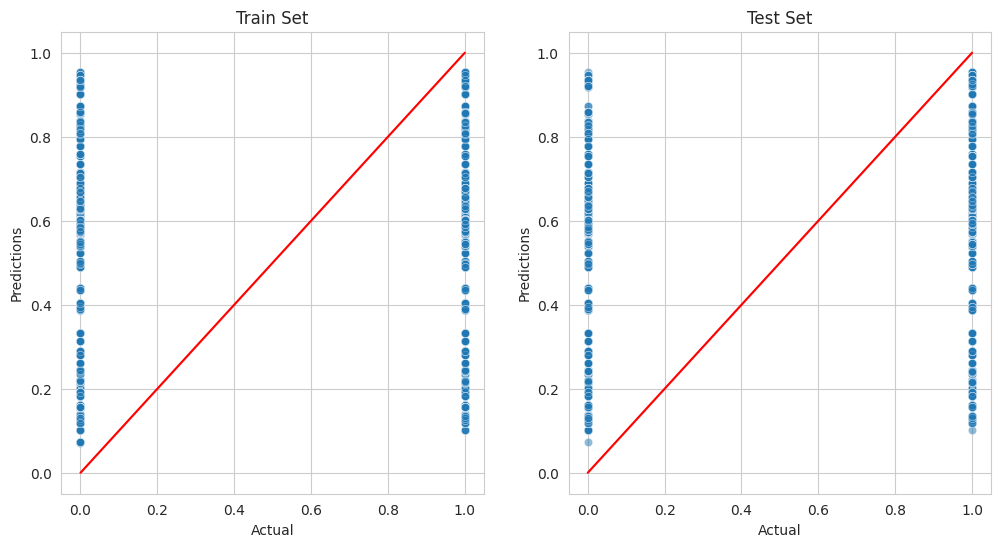

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Regressor with PCA

Let's explore potential values for PCA n_components.

In [20]:
from sklearn.linear_model import LogisticRegression

pipeline = PipelineOptimization(model=LogisticRegression())
pipeline.fit(X_train, y_train)
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(X)

Apply PCA separately to the scaled data

* The 7 components explain 60.02% of the data 



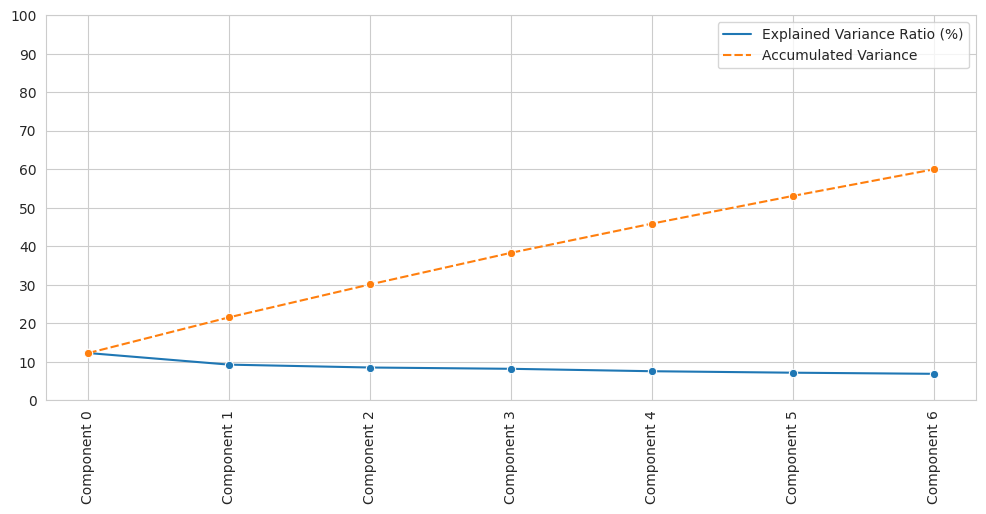

In [21]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 7

def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) 

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum()

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained, 2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio, marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 7 components explain 60.02% of the data 



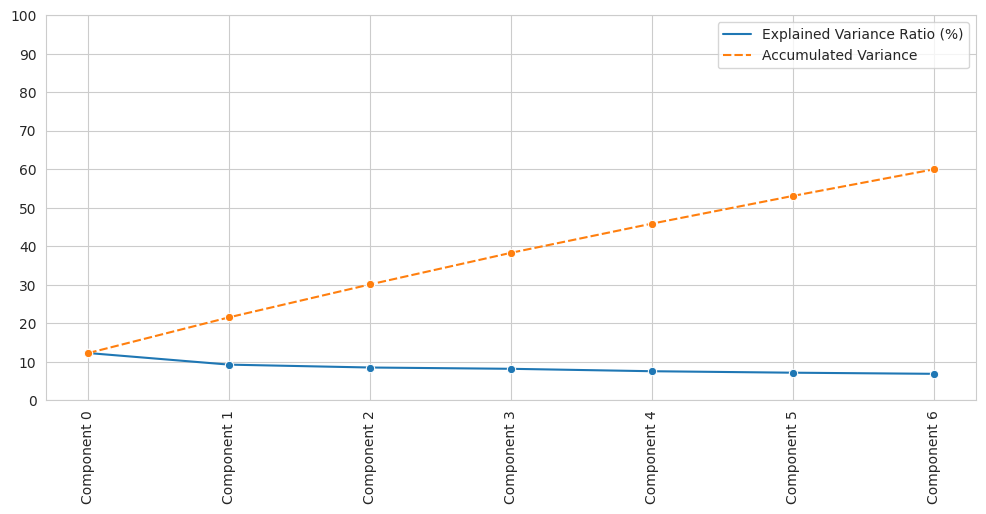

In [22]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite ML Pipeline for Modelling

In [23]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 
                                                                'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
                                                                'OBESITY', 'RENAL_CHRONIC', 'TOBACCO'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", 
                                                               threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base

### Grid Search CV – Sklearn

In [24]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (49788, 14) (49788,) 
* Test set: (12448, 14) (12448,)


#### Use standard hyperparameters to find the most suitable model.

In [25]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a quick optimisation search

In [26]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check results

In [27]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                    estimator min_score mean_score max_score std_score  \
0   GradientBoostingRegressor    0.1601   0.163906  0.168607  0.002929   
7   GradientBoostingRegressor  0.160389   0.163784  0.168215    0.0028   
1   GradientBoostingRegressor  0.158379   0.162851  0.167754  0.003103   
9   GradientBoostingRegressor  0.156958   0.161058  0.165694  0.002869   
2   GradientBoostingRegressor  0.156581   0.161011  0.165709  0.002973   
4   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002973   
3   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002974   
5   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002974   
11  GradientBoostingRegressor  0.156803   0.160988  0.165619  0.002883   
8   GradientBoostingRegressor  0.138681   0.141307  0.145142  0.002236   
6   GradientBoostingRegressor  0.139238   0.141289  0.144583  0.001978   
10  GradientBoostingRegressor  0.138575   0.141251  0.145042  0.002215   
15  GradientBoostingRegressor   0.0730

#### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [28]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3], 
        'model__max_depth': [3, 10, None],
    }
}

Extensive GridSearch CV

In [29]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results

In [30]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                    estimator min_score mean_score max_score std_score  \
0   GradientBoostingRegressor    0.1601   0.163906  0.168607  0.002929   
7   GradientBoostingRegressor  0.160389   0.163784  0.168215    0.0028   
1   GradientBoostingRegressor  0.158379   0.162851  0.167754  0.003103   
9   GradientBoostingRegressor  0.156958   0.161058  0.165694  0.002869   
2   GradientBoostingRegressor  0.156581   0.161011  0.165709  0.002973   
4   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002973   
3   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002974   
5   GradientBoostingRegressor  0.156578    0.16101  0.165709  0.002974   
11  GradientBoostingRegressor  0.156803   0.160988  0.165619  0.002883   
8   GradientBoostingRegressor  0.138681   0.141307  0.145142  0.002236   
6   GradientBoostingRegressor  0.139238   0.141289  0.144583  0.001978   
10  GradientBoostingRegressor  0.138575   0.141251  0.145042  0.002215   
15  GradientBoostingRegressor   0.0730

Check the best model

In [31]:
best_model = grid_search_summary.iloc[0, 0]
print(best_model)

GradientBoostingRegressor


Parameters for best model

In [32]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor

In [33]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
                   

### Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.167
Mean Absolute Error: 0.407
Mean Squared Error: 0.203
Root Mean Squared Error: 0.451


* Test Set
R2 Score: 0.165
Mean Absolute Error: 0.408
Mean Squared Error: 0.204
Root Mean Squared Error: 0.452




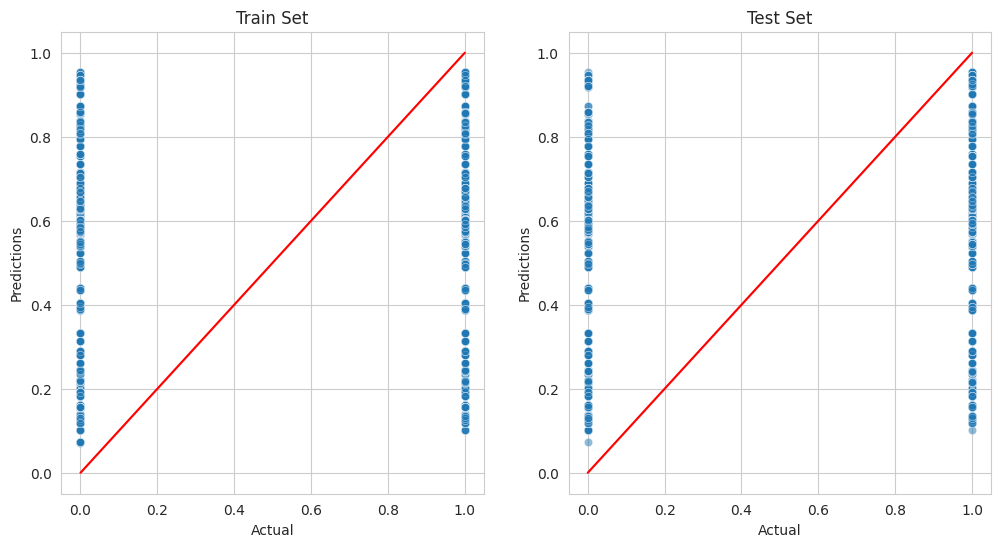

In [34]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

## Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
0-10       1592
11-20      1245
21-30      2971
31-40      5595
41-50      9000
51-60     12333
61-70     12827
71-80     10122
81-90      5501
91-100     1003
nan          47
Name: AGE_BIN, dtype: int64 



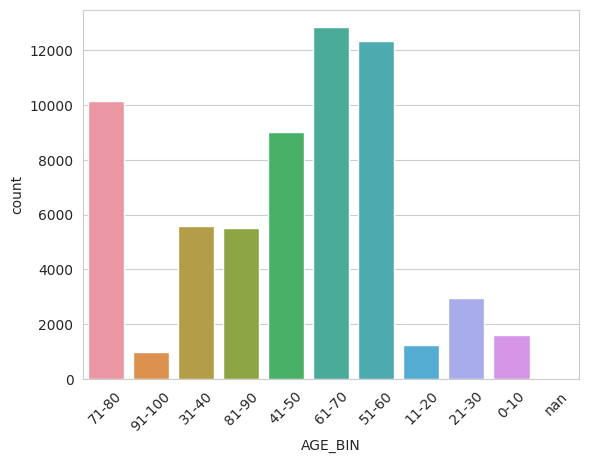

,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DIED,AGE_BIN
0,Male,No,No,76,No,No,No,No,Yes,Yes,No,No,No,No,0,71-80
1,Male,No,Yes,91,Yes,No,No,No,Yes,No,No,No,No,No,0,91-100
2,Male,No,Yes,39,No,No,No,No,No,No,No,No,No,No,1,31-40


In [35]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
import seaborn as sns
import matplotlib.pyplot as plt

bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

df['AGE_BIN'] = pd.cut(df['AGE'], bins=bin_edges, labels=bin_labels, right=False)
df['AGE_BIN'] = df['AGE_BIN'].astype(str)

print(f"* The classes represent the following ranges: \n{df['AGE_BIN'].value_counts().sort_index()} \n")

sns.countplot(data=df, x='AGE_BIN')
plt.xticks(rotation=45)
plt.show()

df.head(3)

#### Define Features and Target for Classification

In [36]:
X = df.drop(['AGE', 'AGE_BIN'], axis=1)
y = df['AGE_BIN'].astype(str)

# Ensure all categorical features are of type 'category'
categorical_columns = ['SEX', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
                       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 
                       'INTUBED', 'PNEUMONIA']

X[categorical_columns] = X[categorical_columns].astype('category')

# Convert y to categorical type
y = y.astype('category')

# Split Train Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (49788, 14) (49788,) 
* Test set: (12448, 14) (12448,)


### Rewrite ML Pipeline for Modelling

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

def cast_to_category(X):
    for col in categorical_columns:
        X[col] = X[col].astype('category')
    return X

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("cast_to_category", FunctionTransformer(cast_to_category)),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=categorical_columns)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", 
                                                               threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("PCA", PCA(n_components=7, random_state=0)), 
        ("model", model),
    ])
    return pipeline_base

### Load algorithms for classification

In [42]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.svm import SVC

### Split Train Test Sets

In [43]:
X = df.drop(['DIED'], axis=1)
y = df['DIED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


### Grid Seach CV – Sklearn

#### Use standard hyper parameters to find most suitable model

In [45]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(probability=True),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': [100, 200]
    },
    "SVC": {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

#### GridSearch CV for each model

In [46]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/tmp/ipykernel_1967/875619258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1967/875619258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1967/875619258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1967/87561925

NotFittedError: All estimators failed to fit

#### Check Results

In [47]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

ValueError: No objects to concatenate

#### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [48]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}

Extensive GridSearch CV

In [50]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/tmp/ipykernel_1967/875619258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1967/875619258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1967/875619258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1967/87561925

NotFittedError: All estimators failed to fit

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

- We are saving this content for later

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

### Assess feature importance

We can assess feature importance for this model with .feature_importances_

In [ ]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Classifier on Train and Test Sets

Custom Function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline, label_map):
    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=y, y_pred=prediction),
          columns=[f"Actual {sub}" for sub in label_map.values()],
          index=[f"Prediction {sub}" for sub in label_map.values()]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=list(label_map.values())), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

List that relates the classes and died

In [ ]:
disc.binner_dict_['DIED']

We can create manually

In [ ]:
label_map = ['<4.0', '4.0 to 20.0','+20.0']
label_map

In [ ]:
clf_performance(X_train=X_train, y_train=y_train, 
                X_test=X_test, y_test=y_test, 
                pipeline=pipeline_clf, label_map=labels_map)

### Which pipeline to choose?

We fitted 3 pipelines:

- Regression
- Regression with PCA
- Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon.

- It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
- Class 1 (4 to 20 months) has weak performance.

In [ ]:
pipeline_clf

### Refit pipeline with best features

#### Rewrite Pipeline

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['SEX', 'DIABETES', 'COPD', 
                                                                'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 
                                                                'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 
                                                                'TOBACCO'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", 
                                                               threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("PCA", PCA(n_components=7, random_state=0)), 
        ("model", model),
    ])
    return pipeline_base

### Split Train Test Set, only with best features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

Subset Best Features

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

#### Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [ ]:
from sklearn.metrics import make_scorer, recall_score

search = HyperparameterOptimizationSearch(models=models_search, params=params_search, categorical_columns=categorical_columns)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, average='macro'),
           n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

# Check the best model
best_model = grid_search_summary.iloc[0, 0]
print("Best Model:", best_model)

# Define the best clf pipeline
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
print(pipeline_clf)

### Assess feature importance

In [ ]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .fit_transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Classifier on Train and Test Sets

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=labels_map)

### Push files to the repo

We will generate the following files

- Train set
- Test set
- Modeling pipeline
- label map
- features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_severity/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

### Train Set: features and target

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:

y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: features and target

In [ ]:
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling pipeline

ML pipeline for predicting tenure

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

### List mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [ ]:

labels_map

In [ ]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

### Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')